# King et al 2020 Exploratory Data Analysis

**Authorship:**<br>
Created by: Adam Klie, *11/18/2022*<br>
Last updated: Adam Klie, *02/04/2023*
***
**Description:**
Notebook to explore the CRE MPRA dataset from King et al 2020. More info can be found here: https://www.notion.so/adamklie/king20-01bc9b4d143944e49a238d8eb1d84a8d
***

In [1]:
import os
import numpy as np
import pandas as pd

# Load data

In [2]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

In [3]:
design_file = os.path.join(dataset_dir, "king20", "design.xlsx")

In [4]:
synthetic_design_df = pd.read_excel(design_file, sheet_name=1)

# Check how many sequences and barcodes we have
Note we have 8 barcodes per sequence, so we need to collapse based on sequence.

In [5]:
# How many Basal barcodes are there
len(synthetic_design_df[synthetic_design_df["Element_id"] == "Basal"])

112

In [6]:
# How many none "SYN" sequences do we have?
len(synthetic_design_df[synthetic_design_df["Element_id"].str.contains("Scalar")].groupby("Sequence").count())

12

In [7]:
# Do we have any sequences with more or less than 8 barcodes?
(synthetic_design_df.groupby("Sequence").count()["Barcode"] != 8).sum()

0

In [8]:
# Basal should
(synthetic_design_df.groupby("Element_id").count()["Barcode"] != 8).sum()

1

In [9]:
# Make sure all the Sequences that are the same have the same Element_id
(synthetic_design_df.groupby("Sequence").agg(lambda x: len(set(x)))["Element_id"] != 1).sum()

0

In [10]:
# Collapse based on Sequence column
synthetic_design_df = synthetic_design_df.drop_duplicates(subset="Sequence")
len(synthetic_design_df)

637

# Explore how the sequences are composed

In [11]:
# Split full site sequence into individual site positions
site_sequence = [el[0] for el in synthetic_design_df["Element_id"].str.split("_")]
site_sequence_split = [el.split("-") for el in site_sequence]
len(site_sequence_split)

637

In [12]:
# Pad the shorter lists with np.nan
max_len = max([len(el) for el in site_sequence_split])
site_sequence_split_padded = [el + [np.nan] * (max_len - len(el)) for el in site_sequence_split]
len(site_sequence_split_padded)

637

In [13]:
# Add the site sequences to the dataframe
synthetic_design_df[["site_1", "site_2", "site_3", "site_4"]] = site_sequence_split_padded

In [14]:
# Check how many position 3 TFBS's we have
synthetic_design_df["site_3"].value_counts(dropna=False)

Er     72
Kf     72
Sr     72
Ef     72
Sf     72
Kr     72
Or     72
Of     72
NaN    61
Name: site_3, dtype: int64

In [15]:
# Check how many position 4 TFBS's we have
synthetic_design_df["site_4"].value_counts(dropna=False)

NaN    253
Sf      48
Er      48
Of      48
Or      48
Ef      48
Kf      48
Kr      48
Sr      48
Name: site_4, dtype: int64

In [16]:
# Check how many position 1 TFBS's we have, this is where the 12 "Scalar" labeled sequence come out
synthetic_design_df["site_1"].value_counts(dropna=False)

Or          78
Kf          78
Kr          78
Ef          78
Of          78
Sf          78
Sr          78
Er          78
SfOfSfKf     1
KfEfSfEf     1
KrSrSfSr     1
KfSfKfEr     1
KfOrSr       1
OfOrOfOr     1
KfSrOfKr     1
OrKrEf       1
SrKf         1
EfOrOf       1
SrKfSrKr     1
Basal        1
KfKfErSr     1
Name: site_1, dtype: int64

In [17]:
# Drop the Barcode column
synthetic_design_df.drop("Barcode", axis=1, inplace=True)
len(synthetic_design_df)

637

In [18]:
# Drop the row with Element_id "Basal"
synthetic_design_df = synthetic_design_df[synthetic_design_df["Element_id"] != "Basal"]
len(synthetic_design_df)

636

In [19]:
# Pull out the sequences
sequences = synthetic_design_df["Sequence"].values
len(sequences)

636

# SeqData analysis

In [52]:
import seqdata as sd
from seqdata._preprocess.basic import reverse_complement_seq

In [21]:
# Create a SeqData object
sdata = sd.SeqData(
    seqs=sequences,
    names=synthetic_design_df["Element_id"].values,
    seqs_annot=synthetic_design_df.drop("Sequence", axis=1).set_index("Element_id"),
)
sdata

SeqData object with = 636 seqs
seqs = (636,)
names = (636,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'site_1', 'site_2', 'site_3', 'site_4'
pos_annot: None
seqsm: None
uns: None

In [22]:
# Simple function to incorporate into SeqData for measuring seq lens
def seq_len(seq, ohe=False):
    if ohe:
        return seq.shape[1]
    else:
        return len(seq)

def seq_lens(seqs, ohe=False):
    if ohe:
        return np.array([seq.shape[1] for seq in seqs])
    else:
        return np.array([len(seq) for seq in seqs])

def seq_len_sdata(sdata, copy=False):
    if sdata.seqs is not None:
        sdata["seq_len"] = seq_lens(sdata.seqs, ohe=False)
    elif sdata.ohe_seqs is not None:
        sdata["seq_len"] = seq_lens(sdata.ohe_seqs, ohe=True)
    else:
        raise ValueError("No sequences found in sdata")

In [23]:
# Make sure Basal didn't sneak in
sdata.seqs[np.where(sdata.names=="Basal")[0]]

array([], dtype=object)

In [24]:
# Calculate seq lens
seq_len_sdata(sdata)
sdata["seq_len"].value_counts()

80    392
60    195
40     49
Name: seq_len, dtype: int64

In [ ]:
# Building block - replace all X with .
building_block = "AGCTA(C|G)XXXXXXXXXXXXGT"
building_block = building_block.replace("X", ".")
building_block

In [67]:
# These are the motifs described in a previous publication from this group
sox2 = "GCTCATTGTTTC"
pou5f1 = "GGGATGCTAATC"
esrrb = "GTTCAAGGTCAC"
klf4 = "GGGGTGGGGCCG"
sox2_rev = reverse_complement_seq(sox2)
pou5f1_rev = reverse_complement_seq(pouf5f1)
esrrb_rev = reverse_complement_seq(esrrb)
klf4_rev = reverse_complement_seq(klf4)

In [68]:
# Get a list of spans for all the building block instances in each sequence, some may overlap
import re
def get_spans(seq, pattern):
    return [m.span() for m in re.finditer(pattern, seq)]
building_block_spans = [get_spans(seq, building_block) for seq in sequences]

In [69]:
# Check the spans for the sequences for the building block
building_block_spans[0], len(building_block_spans)

([(0, 20), (20, 40), (40, 60), (60, 80)], 636)

In [71]:
# Get the spans for each consensus as defined above
sox2_spans = [get_spans(seq, sox2) for seq in sequences]
pou5f1_spans = [get_spans(seq, pou5f1) for seq in sequences]
esrrb_spans = [get_spans(seq, esrrb) for seq in sequences]
klf4_spans = [get_spans(seq, klf4) for seq in sequences]
sox2_rev_spans = [get_spans(seq, sox2_rev) for seq in sequences]
pou5f1_rev_spans = [get_spans(seq, pou5f1_rev) for seq in sequences]
esrrb_rev_spans = [get_spans(seq, esrrb_rev) for seq in sequences]
klf4_rev_spans = [get_spans(seq, klf4_rev) for seq in sequences]

In [74]:
# Add these to the dataframe
sdata.seqs_annot["sox2_spans"] = sox2_spans
sdata.seqs_annot["pouf51_spans"] = pou5f1_spans
sdata.seqs_annot["esrrb_spans"] = esrrb_spans
sdata.seqs_annot["klf4_spans"] = klf4_spans
sdata.seqs_annot["sox2_rev_spans"] = sox2_rev_spans
sdata.seqs_annot["pouf51_rev_spans"] = pou5f1_rev_spans
sdata.seqs_annot["esrrb_rev_spans"] = esrrb_rev_spans
sdata.seqs_annot["klf4_rev_spans"] = klf4_rev_spans

In [75]:
# Check for those that have a site 2, see if the element IDs match up with the spans for these Scalar seqs
sdata.seqs_annot

,site_1,site_2,site_3,site_4,seq_len,sox2_spans,pouf51_spans,esrrb_spans,klf4_spans,sox2_rev_spans,pouf51_rev_spans,esrrb_rev_spans,klf4_rev_spans
Element_id,,,,,,,,,,,,,
Or-Kr-Er-Sf_synthetic,Or,Kr,Er,Sf,80,"[(66, 78)]",[],[],[],[],"[(6, 18)]","[(46, 58)]","[(26, 38)]"
Er-Or_synthetic,Er,Or,NaN,NaN,40,[],[],[],[],[],"[(26, 38)]","[(6, 18)]",[]
Or-Sr-Kf-Er_synthetic,Or,Sr,Kf,Er,80,[],[],[],"[(46, 58)]","[(26, 38)]","[(6, 18)]","[(66, 78)]",[]
Kf-Er-Sr-Of_synthetic,Kf,Er,Sr,Of,80,[],"[(66, 78)]",[],"[(6, 18)]","[(46, 58)]",[],"[(26, 38)]",[]
Kr-Sf-Ef-Or_synthetic,Kr,Sf,Ef,Or,80,"[(26, 38)]",[],"[(46, 58)]",[],[],"[(66, 78)]",[],"[(6, 18)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sr-Kf-Ef-Of_synthetic,Sr,Kf,Ef,Of,80,[],"[(66, 78)]","[(46, 58)]","[(26, 38)]","[(6, 18)]",[],[],[]
Sr-Ef-Kf_synthetic,Sr,Ef,Kf,NaN,60,[],[],"[(26, 38)]","[(46, 58)]","[(6, 18)]",[],[],[]
Kr-Sf-Or_synthetic,Kr,Sf,Or,NaN,60,"[(26, 38)]",[],[],[],[],"[(46, 58)]",[],"[(6, 18)]"


In [77]:
# Check for those that have a site 2, see if the element IDs match up with the spans for these Scalar seqs, seems to be missing the klf4
sdata.seqs_annot[sdata.seqs_annot["site_2"].isna()]

,site_1,site_2,site_3,site_4,seq_len,sox2_spans,pouf51_spans,esrrb_spans,klf4_spans,sox2_rev_spans,pouf51_rev_spans,esrrb_rev_spans,klf4_rev_spans
Element_id,,,,,,,,,,,,,
SrKfSrKr_CMF-Scalar,SrKfSrKr,NaN,NaN,NaN,80,[],[],[],[],"[(6, 18), (46, 58)]",[],[],[]
KfSrOfKr_CMF-Scalar,KfSrOfKr,NaN,NaN,NaN,80,[],"[(46, 58)]",[],[],"[(26, 38)]",[],[],[]
EfOrOf_CMF-Scalar,EfOrOf,NaN,NaN,NaN,60,[],"[(46, 58)]","[(6, 18)]",[],[],"[(26, 38)]",[],[]
SrKf_CMF-Scalar,SrKf,NaN,NaN,NaN,40,[],[],[],[],"[(6, 18)]",[],[],[]
OrKrEf_CMF-Scalar,OrKrEf,NaN,NaN,NaN,60,[],[],"[(46, 58)]",[],[],"[(6, 18)]",[],[]
SfOfSfKf_CMF-Scalar,SfOfSfKf,NaN,NaN,NaN,80,"[(6, 18), (46, 58)]","[(26, 38)]",[],[],[],[],[],[]
OfOrOfOr_CMF-Scalar,OfOrOfOr,NaN,NaN,NaN,80,[],"[(6, 18), (46, 58)]",[],[],[],"[(26, 38), (66, 78)]",[],[]
KfOrSr_CMF-Scalar,KfOrSr,NaN,NaN,NaN,60,[],[],[],[],"[(46, 58)]","[(26, 38)]",[],[]
KfSfKfEr_CMF-Scalar,KfSfKfEr,NaN,NaN,NaN,80,"[(26, 38)]",[],[],[],[],[],"[(66, 78)]",[]


# Analyze motifs for TFBS

In [47]:
import motifdata as md
from motifdata._Motif import Motif
from motifdata._Motif import MotifSet
from seqdata._preprocess.encode import decode_seq
from seqdata._preprocess.utils import _token2one_hot

In [29]:
# Define where the motifs downloaded from JASPAR are
motif_dir = os.path.join(dataset_dir, "king20", "motifs")

In [30]:
# Building block - replace all X with .
building_block = "AGCTA(C|G)XXXXXXXXXXXXGT"
building_block = building_block.replace("X", ".")
building_block

'AGCTA(C|G)............GT'

In [36]:
# Test out the load of a motif from MEME
klf4_motif = md._io.read_meme(os.path.join(motif_dir, "MA0039.2.meme"))

In [37]:
# Print the strands
klf4_motif.strands

'+ -'

In [38]:
# Print the motifs
klf4_motif.motifs

{'MA0039.2': Motif MA0039.2 (Klf4) with 10 positions}

In [40]:
# Now just load directly from Jaspar
jaspar_pwms = md._io.load_jaspar(motif_accs=["MA0141.1", "MA0039.2", "MA0142.1"])

In [41]:
# Check the motifs
jaspar_pwms.motifs

{'MA0141.1': Motif MA0141.1 (Esrrb) with 12 positions,
 'MA0039.2': Motif MA0039.2 (Klf4) with 10 positions,
 'MA0142.1': Motif MA0142.1 (Pou5f1::Sox2) with 15 positions}

In [42]:
# Grab the POU5F1-SOX2 composite to clean up
pouf5f1_sox2_jaspar = jaspar_pwms["MA0142.1"]

In [45]:
# Clean the motifs
sox2_jaspar = Motif(
    name="Sox2",
    identifier= "Sox2",
    pfm=pouf5f1_sox2_jaspar.pfm[:8],
    length=8,
    consensus=pouf5f1_sox2_jaspar.consensus[:8],
)
pouf5f1_jaspar = Motif(
    name="Pouf5f1",
    identifier= "Pouf5f1",
    pfm=pouf5f1_sox2_jaspar.pfm[8:],
    length=7,
    consensus=pouf5f1_sox2_jaspar.consensus[8:],
)
essrb_jaspar = jaspar_pwms.motifs["MA0141.1"]
klf4_jaspar = jaspar_pwms.motifs["MA0039.2"]

In [48]:
# Generate a motif set
motif_dict = {
    "Sox2": sox2_jaspar,
    "Pouf5f1": pouf5f1_jaspar,
    "Essrb": essrb_jaspar,
    "Klf4": klf4_jaspar,
}
motif_set = MotifSet(
    motifs=motif_dict,
    alphabet="ACGT",
    background={'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25},
    strands='+ -',
    version="4"
)

In [49]:
# Write the set to a file
md._io.write_meme(motif_set, os.path.join(motif_dir, "all_pwms.meme"))

Saved pfm in MEME format as: /cellar/users/aklie/data/eugene/king20/motifs/all_pwms.meme


In [50]:
# Print out the consensus motifs
print(sox2_jaspar.consensus)
print(pouf5f1_jaspar.consensus)
print(essrb_jaspar.consensus)
print(klf4_jaspar.consensus)

CTTTGTTA
TGCAAAT
AGCTCAAGGTCA
TGGGTGGGGC


In [10]:
sdata = king20("SYN", dataset_dir=dataset_dir, return_sdata=True)

Finished downloading king20 design spreadsheet to /cellar/users/aklie/data/eugene/king20/design.xlsx
Finished downloading king20 spreadsheet to /cellar/users/aklie/data/eugene/king20/models.xlsx


# Test scanning Sox2 ChIP peaks for Sox2 motifs defined above

In [79]:
import os
import sys

In [ ]:
!wget wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE11nnn/GSE11431/suppl/GSE11431_readme.txt
!wget https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE11431

## Step 1: Liftover peak regions coordinates from mm8 to mm10
More detailed directions on how to get this set-up on your machine can be found on the Notion.

In [ ]:
!wget http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/liftOver -O /cellar/users/aklie/opt/ucsc/liftOver
!wget https://hgdownload.soe.ucsc.edu/goldenPath/mm8/liftOver/mm8ToMm10.over.chain.gz -O /cellar/users/aklie/opt/ucsc/mm8ToMm10.over.chain.gz

In [6]:
%%bash
lo_path=/cellar/users/aklie/opt/ucsc/liftOver
chain_path=/cellar/users/aklie/opt/ucsc/mm8ToMm10.over.chain.gz
prebed_path=/cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2.bed
postbed_path=/cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10.bed
unmapped_path=/cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10_unmapped.bed
echo $lo_path $prebed_path $chain_path $postbed_path $unmapped_path

/cellar/users/aklie/opt/ucsc/liftOver /cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2.bed /cellar/users/aklie/opt/ucsc/mm8ToMm10.over.chain.gz /cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10.bed /cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10_unmapped.bed


## Step 2: Extend peaks and remove blacklisted regions

In [ ]:
!wget http://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.chrom.sizes -O data/mm10.chrom.sizes
!wget https://github.com/Boyle-Lab/Blacklist/raw/master/lists/mm10-blacklist.v2.bed.gz -O data/mm10-blacklist.v2.bed.gz
!wget http://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.fa.gz -O data/mm10.fa.gz
!gunzip data/mm10-blacklist.v2.bed.gz
!gunzip data/mm10.fa.gz

In [80]:
# Have to do this to get pybedtols to work
bin_dir = os.path.dirname(sys.executable)
os.environ["PATH"] += os.pathsep + bin_dir
from pybedtools import paths
paths._set_bedtools_path(bin_dir)
from pybedtools import BedTool

In [81]:
# Get the bed file path
peaks_dir = os.path.join(dataset_dir, "king20", "GSE11431")
sox2_bed = os.path.join(peaks_dir, "GSM288347_Sox2.bed.gz")

In [82]:
# Create a bed tool object
sox2_chip = BedTool(os.path.join(peaks_dir, "GSM288347_Sox2_mm10.bed"))
sox2_chip.sort().head()

chr1	3011454	3011479	0	0	+
 chr1	3011556	3011581	0	0	+
 chr1	3012228	3012253	0	0	-
 chr1	3012409	3012434	0	0	+
 chr1	3012677	3012702	0	0	+
 chr1	3013081	3013106	0	0	+
 chr1	3013224	3013249	0	0	-
 chr1	3013732	3013757	0	0	+
 chr1	3014445	3014470	0	0	+
 chr1	3018959	3018984	0	0	+
 

In [15]:
# Extend each peak 100bp, remove blacklisted regions and save to new bed
sox2_chip.slop(b=100, g="/cellar/users/aklie/data/eugene/king20/mm10.chrom.sizes") \
.sort().merge().subtract("/cellar/users/aklie/data/eugene/king20/mm10-blacklist.v2.bed") \
.saveas(os.path.join(peaks_dir, "GSM288347_Sox2_mm10_100bp.bed"))

<BedTool(/cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10_100bp.bed)>

In [ ]:
# Convert bed to fasta
BedTool(os.path.join(peaks_dir, "GSM288347_Sox2_mm10_100bp.bed")) \
.sequence(fi=os.path.join(dataset_dir, "mm10.fa")), \
.save_seqs(os.path.join(peaks_dir, "GSM288347_Sox2_mm10_100bp.fa")

## Step 3: Run FIMO on these regions with motifs

In [22]:
%%bash
fimo_path=/cellar/users/aklie/opt/meme/bin/fimo
motif_path=/cellar/users/aklie/data/eugene/king20/motifs/all_pwms.meme
fasta_path=/cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10_100bp.fa
output_dir=/cellar/users/aklie/data/eugene/king20/fimo
echo $fimo_path--thresh 1e-3 --o $output_dir $motif_path $fasta_path

/cellar/users/aklie/opt/meme/bin/fimo --thresh 1e-3 /cellar/users/aklie/opt/meme/bin/fimo /cellar/users/aklie/data/eugene/king20/motifs/all_pwms.meme /cellar/users/aklie/data/eugene/king20/GSE11431/GSM288347_Sox2_mm10_100bp.fa


# EUGENe analysis

In [5]:
import sys
sys.path.append("/cellar/users/aklie/projects/use_cases/king20/")
from utils import *
import eugene as eu

In [6]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

In [7]:
sdata = king20(dataset="SYN", dataset_dir=dataset_dir)

Design spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/design.xlsx
Model spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/models.xlsx


In [8]:
sdata

SeqData object with = 637 seqs
seqs = (637,)
names = (637,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E'
pos_annot: None
seqsm: None
uns: None

## Data Visualization

In [14]:
sdata = sdata[~np.array([seq is np.nan for seq in sdata.seqs])]

In [15]:
# Get seq lens
seq_len_sdata(sdata)

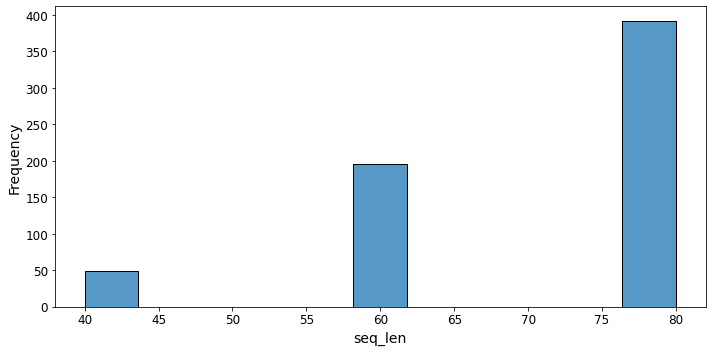

In [16]:
# Add this to some kind of preprocess seqs or seqs metrics
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

12


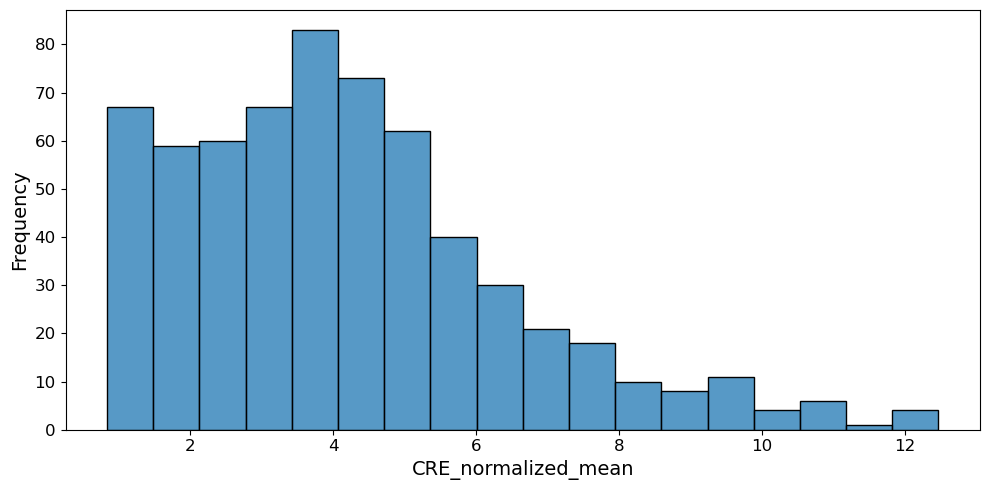

In [17]:
# Chceck the potential target to start
eu.pl.histplot(
    sdata,
    keys="CRE_normalized_mean",
    orient="h"
)
print(sdata["CRE_normalized_mean"].isna().sum())

## Preprocessing

In [18]:
# One-hot-encode, though this is no bueno
eu.pp.ohe_seqs_sdata(sdata, maxlen=sdata["seq_len"].max())

One-hot encoding sequences:   0%|          | 0/636 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 636 ohe_seqs added


In [19]:
# Add function registry for normalization
sdata["log_CRE_normalized_mean"] = np.log2(sdata["CRE_normalized_mean"])

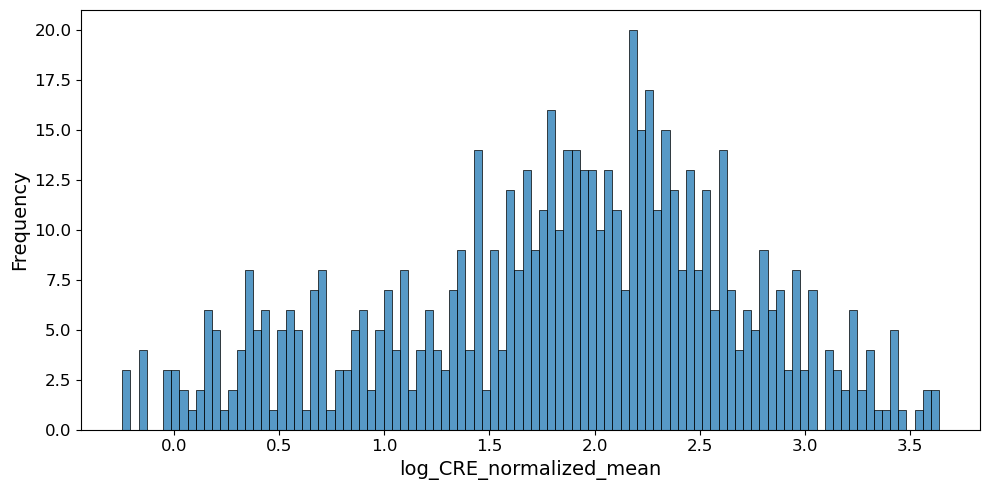

In [20]:
# Check log normalization
eu.pl.histplot(
    sdata,
    keys="log_CRE_normalized_mean",
    orient="h",
    bins=100
)

In [21]:
# Clean up features to use
sdata.seqs_annot = sdata.seqs_annot.replace({True: 1, False: 0})

In [22]:
eu.pp.train_test_split_sdata(sdata, split=0.5)

SeqData object modified:
    seqs_annot:
        + train_val


In [23]:
nan_mask = np.isnan(sdata["log_CRE_normalized_mean"])
sdata = sdata[~nan_mask]

In [24]:
sdata

SeqData object with = 624 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E', 'seq_len', 'log_CRE_normalized_mean', 'train_val'
pos_annot: None
seqsm: None
uns: None

# DONE!

---